In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
from collections import OrderedDict
import pandas as pd
import re

In [2]:
direc = '/raid/gergel/rasm/agu_2016'
domain_file = 'domain.lnd.wr50a_ar9v4.130607.nc'
params_file = os.path.join('/raid/gergel/rasm/rasm_25_km', 'vic_params_wr25b_vic5.0.dev_20170530.nc')
calm_params_file = os.path.join(direc, 'params_calm_sites_11282016.nc')
domain_file_calm = os.path.join(direc, 'calm_domain_file_adj_11282016.nc')

In [4]:
calm_params = xr.open_dataset(calm_params_file)
calm_domain = xr.open_dataset(domain_file_calm)
domain = xr.open_dataset(os.path.join(direc, domain_file))

__WANT__: all three Alaska sites with soil temp data at three depths (Barrow, Toolik, and West Dock). West Dock has two sites. Are they in the same RASM grid cell? If so, maybe not that helpful to use both. 

THEN: sites with varied veg types, avg_T, thickness of soil layers, number of veg types, locations. Also sites that have less sparse yearly ALT data (so look at CALM time series to check number of NaNs). 

__IN TOTAL__: want 20 or so sites, maybe 30. But fewer if we can capture the above characteristics with fewer sites. Just want to make sure we have a good range in the included sites. 

these functions are taken from my metadata notebook, see read_calm_metadata.ipynb 

In [39]:
def parse_calm_lat_or_lon(x):
    '''takes in lat or lon from CALM data and produces list of degree, minutes, seconds
    or decimal. If element is a decimal, returns decimal as a float. If not decimal, 
    or decimal with direction, it returns a decimal without the direction as a float'''
    # symbols to parse by
    upside_down_exc = '¡'
    degree_sign= u'\N{DEGREE SIGN}'
    single_quote = "'"
    double_quote = '''"'''
    space = " "
    comma = ","
    v = 'v'
    zero_aigu = calm['lat'][70][8]
    # combine all symbols into one reg ex
    split_on = '%s|\s|%s|%s|%s|%s|%s|%s|%s|' % (upside_down_exc, degree_sign, single_quote, 
                                             double_quote, space, comma, v, zero_aigu)
    # parse lat or lon with reg ex 
    splitt = re.split(split_on, x)

    # remove comma and v characters from strings in parsed list 
    chars_to_remove = [',' 'v']
    for char_to_remove in chars_to_remove:
        if char_to_remove in splitt: 
            splitt.remove(char_to_remove)
            
    # remove empty strings from parsed list 
    parsed_list = list(filter(None, splitt))

    # 4 cases 
    if len(parsed_list) == 1:
        # decimal so leave as is but convert to float
        return(float(parsed_list[0]))
    elif len(parsed_list) == 2: 
        # decimal with direction, remove direction, return first element as float
        # with the correct sign 
        direction = parsed_list[1]
        if direction == "S" or direction == "W": 
            return(float(parsed_list[0]) *-1)
        else: 
            return(float(parsed_list[0]))
    else:
        # degree, min, sec OR min, sec; convert to decimal. 
        if len(parsed_list) == 3:
            # case with no minutes
            dd = float(parsed_list[0]) + float(parsed_list[1])/60.0
            direction = parsed_list[2]
        elif len(parsed_list) == 4:
            # case where minutes are included
            '''print(parsed_list[2])
            print(type(parsed_list[2][2][0]))'''
            dd = (float(parsed_list[0]) + float(parsed_list[1])/60.0 
                  + float(parsed_list[2])/(60.0*60.0))
            direction = parsed_list[3]
        if direction == "S" or direction == "W":
            dd *= -1
        return(dd)
    
def convert_longitude_0_360(longitude):
    ''' takes in longitude between -180 to 180 and converts it to the 0 to 360 longitude'''
    lng = np.mod(longitude, 360)
    return lng 

def get_nj_ni_indices(lat, lng, domain):
    ''' takes in CALM latitude and longitude (not in 0-360 format) and an xarray dataset of 
    a domain file and returns nj and ni indices'''
    lng_adj = convert_longitude_0_360(lng)
    min_arg = (((domain.xc - lng_adj)**2) + ((domain.yc - lat)**2)).argmin()
    nj, ni = np.unravel_index(min_arg, domain.xc.shape)
    return(nj, ni)

'''def get_X(row):
    return utm.from_latlon(row['Latitude'], row['Longitude'])[0]

def get_Y(row):
    return utm.from_latlon(row['Latitude'], row['Longitude'])[1] 

df['X'] = df.apply(get_X, axis=1)
df['Y'] = df.apply(get_Y, axis=1)'''

def get_nj_indices_from_df(df):
    ''' takes in Pandas DataFrame and returns nj Series'''
    domain = xr.open_dataset(os.path.join(direc, domain_file))
    return get_nj_ni_indices(df['lat_dec'], df['lng_dec'], domain)[0]

def get_ni_indices_from_df(df):
    ''' takes in Pandas DataFrame and returns nj Series'''
    domain = xr.open_dataset(os.path.join(direc, domain_file))
    return get_nj_ni_indices(df['lat_dec'], df['lng_dec'], domain)[1]

__read in calm obs data__

In [6]:
calm_metadata = 'CALM_Summary_table_latslons.csv'
calm = pd.read_csv(os.path.join(direc, calm_metadata),
                   delimiter=',',
                   header=0,
                   error_bad_lines=False,
                   nrows=236,
                   encoding='ISO-8859-1')

# rename columns 
calm.rename(index=str, columns={"LAT": "lat", "LONG": "lng"}, inplace=True)

__convert lats/lons form deg min sec to dec format for using nj/ni indices__

In [7]:
calm['lat_dec'] = calm['lat'].apply(parse_calm_lat_or_lon)
calm['lng_dec'] = calm['lng'].apply(parse_calm_lat_or_lon)

# add column to DataFrame for longitudes from 0 to 360 so that I can use them directly with nj/ni indices
calm['lng_dec_360'] = calm['lng_dec'].apply(convert_longitude_0_360)

/home/gergel/anaconda/envs/vic_test_env/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


add nj, ni indices to DataFrame so that I can find grid cells more easily based on their location

In [43]:
calm['nj'] = calm.apply(get_nj_indices_from_df, axis=1)
calm['ni'] = calm.apply(get_ni_indices_from_df, axis=1)

__sites to use__: 

__nj, ni__ indices

__Barrow (Alaska)__: calm[0]: 71.31667, -156.6. (73, 130).

__Toolik LTR (Alaska)__: 68.1667, -149.6. (64, 130).

__West Dock (Alaska)__: 70.36667, -148.55. (67, 133). 
(NOTE: 70.36667, -148.56667 is the 2nd West Dock site, but not using it because it falls in the same grid cell as the other one we're using)

__Pearl Creek (Alaska)__: 64.9, -147.8. (57, 127). 

__Bonanza Creek LTER, Alaska (Interior)__: 64.75, -148. (56, 126)

__Abisko area, Sweden__: 68.33, 18.833. (136, 193). 

__Kapp Linne, Svalbard__: 78.05, 13.6167. (119, 178). 

__Janssonhaugen, Svalbard__: 78.1667, 16.4667. (120, 177)

__Murtel-Corvatsch, Switzerland__: 49.433, 9.833. (156, 236). 

__Northern Tien Shan; Cosmostation, China__: 43.083, 76.91667. (204, 138). 

__Cape Rogozhny, Chukotka, Siberia__: 64.7833, 176.967. (83, 105). 

__Ayach-Yakha, Vorkuta, Russia__: 78.16667, 16.46667. (120, 177). 

__Reindeer Depot (thaw tube), Canada__: 68.6847, -134.146 (59, 142).

__Willowlake River, Canada__: 62.6967, -123.065. (43, 148).

__Marmot Mountain, Canada__: 52.8, -118.117. (19, 152). 

__Baganuur Depression, Mongolia__: 66.315, 76.9077. (156, 148). 

to locate a gridcell in the calm DataFrame

In [94]:
# calm.loc[calm['nj'] == 59]
# print that row: 
calm.ix[94]
# to print range of rows: 
# calm[80:82]

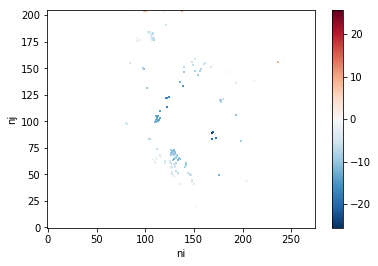

In [18]:
calm_params.avg_T.where(calm_domain.mask == 1).plot()

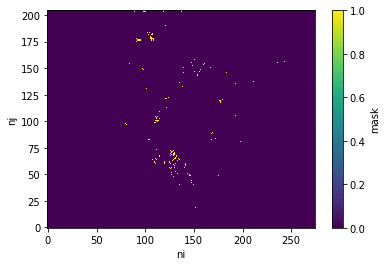

In [19]:
calm_domain.mask.plot()